In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report
import keras

/var/folders/wf/v6kvyp_x0qs8lhlcxvjc8p440000gn/T/ipykernel_4413/3473917113.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Data augmentation

In [2]:
train_data_dir = '../model/dataset/train'
val_data_dir = '../model/dataset/valid/'
test_data_dir = '../model/dataset/test/'

# Image size and batch size
img_size = (350, 350)
batch_size = 64

# Data augmentations performed on training set
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
)

train_images = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
    
)

# Data augmentation for the valdiation set
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

validation_images = validation_datagen.flow_from_directory(
    val_data_dir,
    color_mode='rgb',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Data augmentation performed on testing set
testing_datagen = ImageDataGenerator(
    rescale=1./255.,
)

testing_images = testing_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


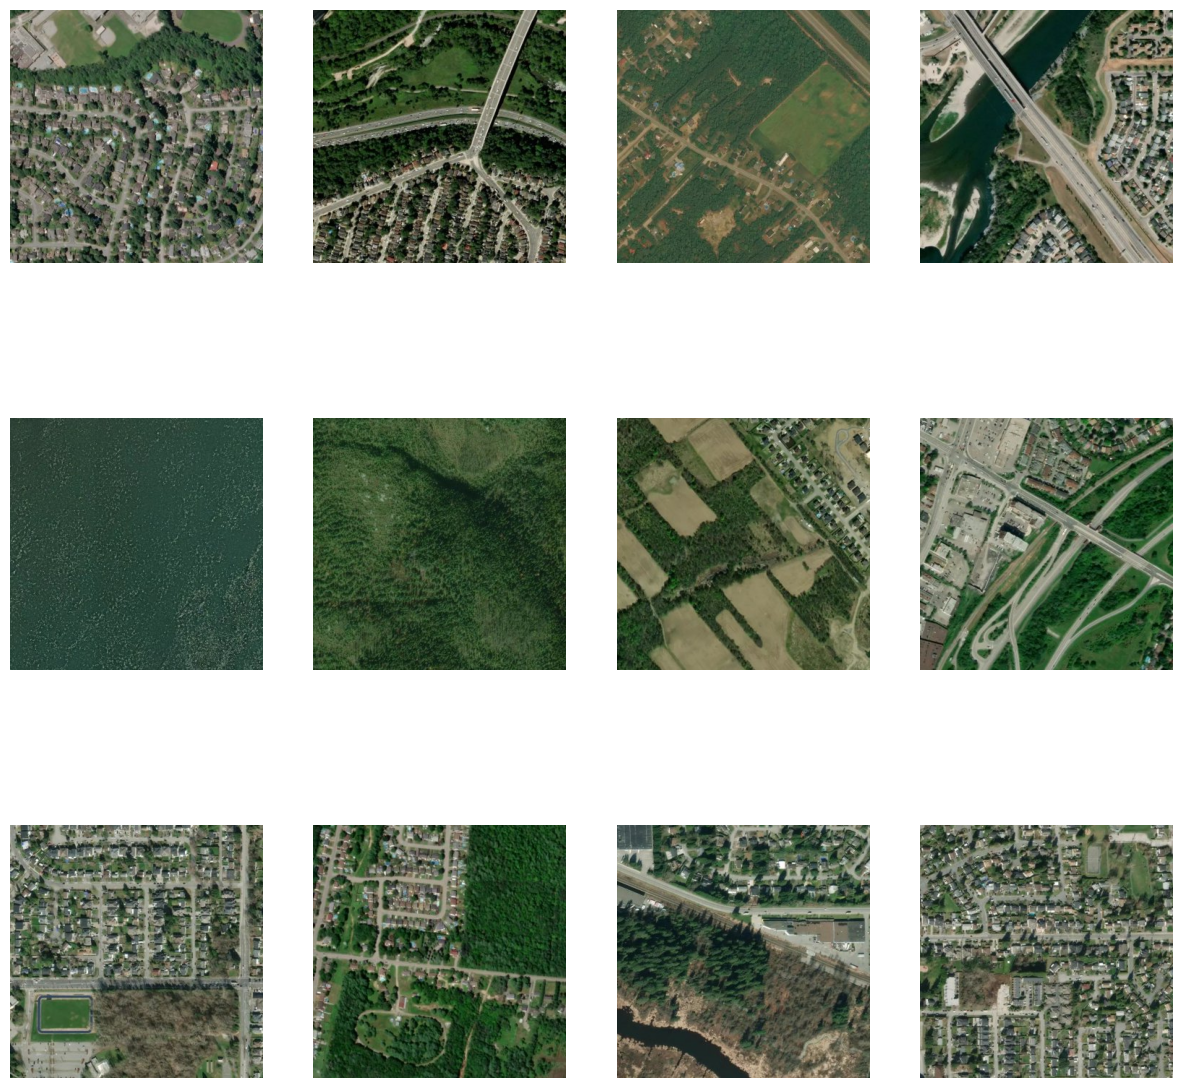

In [3]:
plt.figure(figsize=(15, 15))
for images, labels in train_images:
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) 
        image = images[i]

        plt.imshow(image)
      
        plt.axis("off")
    break  # To show only the first batch
plt.show()  # To display the plot

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from tensorflow.keras import layers, models


model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(350, 350, 3), padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu',  padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu',  padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.15),
  
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') 
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=train_images.samples // batch_size,
    epochs=14,
    validation_data=validation_images,
    
     callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
       
    ]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 350, 350, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 175, 175, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 175, 175, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 87, 87, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 43, 43, 64)        0

In [5]:
result = model.evaluate(testing_images)

print("Test loss: {:.5f}".format(result[0]))
print("Test accuracy: {:.2f}%".format(result[1] * 100))


# Predict on the test set
predictions = model.predict(testing_images)

# Get predicted classes
predicted_classes = (predictions > 0.5).astype(int)  

# Get true classes
true_classes = testing_images.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Test Accuracy: {accuracy}')

# Generate a classification report
class_report = classification_report(true_classes, predicted_classes)
print('Classification Report:\n', class_report)

99/99 [==============================] - 20s 200ms/step - loss: 0.0708 - accuracy: 0.9748
Test loss: 0.07083
Test accuracy: 97.48%
99/99 [==============================] - 20s 197ms/step
Test Accuracy: 0.9747619047619047
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2820
           1       0.98      0.98      0.98      3480

    accuracy                           0.97      6300
   macro avg       0.97      0.97      0.97      6300
weighted avg       0.97      0.97      0.97      6300



Confusion matrix

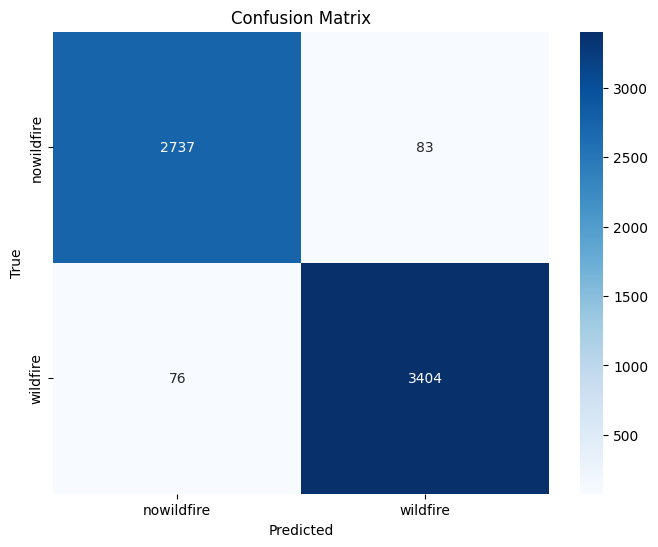

In [6]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=testing_images.class_indices,
            yticklabels=testing_images.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#Save the model 
model.save('../app/wildfiremodel.h5')